# Exploratory Data Analysis for Urea Pricing
---

## Feature Engineering + EDA
---

In [1]:
import os
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path

print("All necessary libraries imported successfully.")

All necessary libraries imported successfully.


## Configs and Paths:
---

In [2]:
DATA_DIR = os.path.abspath("./data")
DATA_DIR = Path(DATA_DIR)
RAW_DIR = DATA_DIR / "raw"

paths = {
    "merged": DATA_DIR / "merged_data.csv",
    "pink": RAW_DIR / "pink_sheet_monthly.csv",
    "ptax": RAW_DIR / "bcb_ptax_usdbrl_1990-01_2025-12.csv",
    "gscpi": RAW_DIR / "nyfed_gscpi.csv",
    "oni": RAW_DIR / "noaa_oni.csv",
    "gpr": RAW_DIR / "gpr.csv",
    "events": RAW_DIR / "main_events.csv",
    "trade": DATA_DIR / "urea_trade_features.csv",
    "india": DATA_DIR / "india_urea_hs6_by_partner_wits.csv",
}

OUT_DIR = DATA_DIR / "eda_outputs"
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

UREA_COL = "urea_usd"

In [3]:
def to_month_start(dt_series: pd.Series) -> pd.Series:
    s = pd.to_datetime(dt_series, errors="coerce")
    return s.dt.to_period("M").dt.to_timestamp()

def savefig(fig, filename: str, dpi: int = 160):
    fig.tight_layout()
    fig.savefig(FIG_DIR / filename, dpi=dpi)
    plt.close(fig)

def add_seasonality(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    m = out.index.month.astype(int)
    out["month"] = m
    out["month_sin"] = np.sin(2 * np.pi * m / 12)
    out["month_cos"] = np.cos(2 * np.pi * m / 12)
    return out


def add_lags(df: pd.DataFrame, cols: List[str], lags: List[int]) -> pd.DataFrame:
    out = df.copy()
    new_cols = {}
    for c in cols:
        if c not in out.columns:
            continue
        for L in lags:
            new_cols[f"{c}_lag{L}"] = out[c].shift(L)
    if new_cols:
        out = pd.concat([out, pd.DataFrame(new_cols)], axis=1)
    return out


def add_rolling(df: pd.DataFrame, cols: List[str], windows: List[int]) -> pd.DataFrame:
    out = df.copy()
    new_cols = {}
    for c in cols:
        if c not in out.columns:
            continue
        for w in windows:
            new_cols[f"{c}_ma{w}"] = out[c].rolling(w).mean()
    if new_cols:
        out = pd.concat([out, pd.DataFrame(new_cols)], axis=1)
    return out


def lag_correlation_table(df: pd.DataFrame, target: str, features: List[str], lags: List[int]) -> pd.DataFrame:
    rows = []
    y = df[target]
    for f in features:
        if f not in df.columns:
            continue
        for L in lags:
            corr = y.corr(df[f].shift(L))
            rows.append({"feature": f, "lag": L, "corr": corr})
    out = pd.DataFrame(rows).dropna()
    out["abs_corr"] = out["corr"].abs()
    return out.sort_values(["abs_corr"], ascending=False).reset_index(drop=True)


def train_feature_importance_ts(
    df: pd.DataFrame,
    target: str,
    drop_cols: Optional[List[str]] = None,
    n_splits: int = 5,
    random_state: int = 42,
) -> Tuple[pd.DataFrame, Dict[str, float]]:
    drop_cols = drop_cols or []
    data = df.dropna(subset=[target]).copy()
    X = data.drop(columns=[target] + drop_cols, errors="ignore")
    y = data[target].copy()

    # Remover colunas não-numéricas
    X = X.select_dtypes(include=[np.number]).copy()

    # Tirar linhas com NA após lags/rolling
    mask = X.notna().all(axis=1) & y.notna()
    X = X[mask]
    y = y[mask]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_metrics = {"mae": [], "rmse": [], "r2": []}

    # Modelo simples e interpretável via importâncias + permutação
    model = RandomForestRegressor(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=2,
        random_state=random_state,
        n_jobs=-1,
    )

    # Avaliação em folds e treino final no full (para importâncias)
    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        model.fit(Xtr, ytr)
        pred = model.predict(Xte)
        fold_metrics["mae"].append(mean_absolute_error(yte, pred))
        fold_metrics["rmse"].append(np.sqrt(mean_squared_error(yte, pred)))
        fold_metrics["r2"].append(r2_score(yte, pred))

    metrics_summary = {
        "mae_mean": float(np.mean(fold_metrics["mae"])),
        "rmse_mean": float(np.mean(fold_metrics["rmse"])),
        "r2_mean": float(np.mean(fold_metrics["r2"])),
        "n_obs": int(len(X)),
        "n_features": int(X.shape[1]),
    }

    # Treino final para importâncias
    model.fit(X, y)

    imp_rf = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    perm = permutation_importance(model, X, y, n_repeats=15, random_state=random_state, n_jobs=-1)
    imp_perm = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

    out = pd.DataFrame({
        "feature": X.columns,
        "rf_importance": imp_rf.reindex(X.columns).values,
        "perm_importance": imp_perm.reindex(X.columns).values,
    }).sort_values(["perm_importance", "rf_importance"], ascending=False)

    return out.reset_index(drop=True), metrics_summary


def plot_series(df: pd.DataFrame, cols: List[str], outpath: str, title: str) -> None:
    plt.figure(figsize=(12, 5))
    for c in cols:
        if c in df.columns:
            plt.plot(df.index, df[c], label=c)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=140)
    plt.close()


def plot_bar(df: pd.DataFrame, x: str, y: str, outpath: str, title: str, top_n: int = 20) -> None:
    d = df.head(top_n).copy()
    plt.figure(figsize=(10, 6))
    plt.barh(d[x][::-1], d[y][::-1])
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=140)
    plt.close()

def dataset_overview(name: str, df: pd.DataFrame, date_col: str = None):
    out = {
        "dataset": name,
        "rows": len(df),
        "cols": df.shape[1],
    }
    if date_col and date_col in df.columns:
        d = pd.to_datetime(df[date_col], errors="coerce")
        out["min_date"] = d.min()
        out["max_date"] = d.max()
    else:
        out["min_date"] = pd.NaT
        out["max_date"] = pd.NaT
    out["missing_cells_pct"] = round(float(df.isna().mean().mean() * 100), 3)
    return out


def zscore(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    return (s - s.mean()) / s.std(ddof=0)

## Loading all datasets:
---

In [ ]:
df_merged = pd.read_csv(paths["merged"])
df_merged["date"] = pd.to_datetime(df_merged["date"], errors="coerce")
df_merged = df_merged.sort_values("date").reset_index(drop=True)

df_pink = pd.read_csv(paths["pink"])
df_pink["date"] = pd.to_datetime(df_pink["date"], errors="coerce")

df_ptax = pd.read_csv(paths["ptax"])
df_ptax["date"] = pd.to_datetime(df_ptax["date"], errors="coerce")

df_gscpi = pd.read_csv(paths["gscpi"])
df_gscpi["date"] = pd.to_datetime(df_gscpi["date"], errors="coerce")

df_oni = pd.read_csv(paths["oni"])
df_oni["date"] = pd.to_datetime(df_oni["date"], errors="coerce")

df_gpr = pd.read_csv(paths["gpr"])
df_gpr["date"] = pd.to_datetime(df_gpr["date"], errors="coerce")

df_events = pd.read_csv(paths["events"])
df_events["date"] = pd.to_datetime(df_events["date"], errors="coerce")

df_trade = pd.read_csv(paths["trade"])
df_trade["date"] = pd.to_datetime(df_trade["date"], errors="coerce")
mask = df_trade["flowDesc"] == "Re-import"
df_trade = df_trade[~mask].copy()

df_trade_pivoted = df_trade.pivot_table(
    index='date',
    columns='flowDesc',
    values=['CHN_tonnes', 'CHN_value_usd', 'BRA_tonnes', 'BRA_value_usd'],
    aggfunc='first'
)
df_trade_pivoted.columns = ['_'.join(col).strip() for col in df_trade_pivoted.columns.values]

df_india = pd.read_csv(paths["india"])
df_india["date"] = pd.to_datetime(df_india["year"].astype(str) + "-01-01", errors="coerce")

df_merged = df_merged.set_index("date")
df_merged = df_merged.drop(columns=["index"])

if UREA_COL not in df_merged.columns:
    raise ValueError(f"Coluna-alvo não encontrada: {UREA_COL}")

# Adiciona features de comércio internacional ao dataset principal
df_merged = df_merged.merge(df_trade_pivoted, left_index=True, right_index=True, how="left")
df_merged['urea_brl'] = df_merged[UREA_COL] * df_merged['usdbrl']

df_merged.to_csv(DATA_DIR / "merged_data_with_trade.csv")


# Aplica filtro de data inicial como 1995-01-01.
df_merged = df_merged[df_merged.index >= pd.to_datetime("1995-01-01")]


In [5]:
overview = pd.DataFrame([
    dataset_overview("merged_data.csv", df_merged.reset_index(), "date"),
    dataset_overview("pink_sheet_monthly.csv", df_pink, "date"),
    dataset_overview("ptax_usdbrl.csv", df_ptax, "date"),
    dataset_overview("nyfed_gscpi.csv", df_gscpi, "date"),
    dataset_overview("noaa_oni.csv", df_oni, "date"),
    dataset_overview("gpr.csv", df_gpr, "date"),
    dataset_overview("main_events.csv", df_events, "date"),
    dataset_overview("urea_trade_features.csv", df_trade, "date"),
    dataset_overview("india_urea_hs6_by_partner_wits.csv", df_india, "date"),
])

overview.to_csv(TAB_DIR / "00_dataset_overview.csv", index=False)

In [13]:
entropy_df

,entropy
crude_oil_usd,4.569151
usdbrl,4.445113
urea_usd,4.039143
natural_gas_usd,4.004104
gscpi,3.809522
gpr,3.019001


ENTROPIA DAS FEATURES (em bits)
                  entropy
crude_oil_usd    4.569151
usdbrl           4.445113
urea_usd         4.039143
natural_gas_usd  4.004104
gscpi            3.809522
gpr              3.019001

Interpretação:
- Maior entropia = maior incerteza/variabilidade
- Menor entropia = mais previsível/concentrada


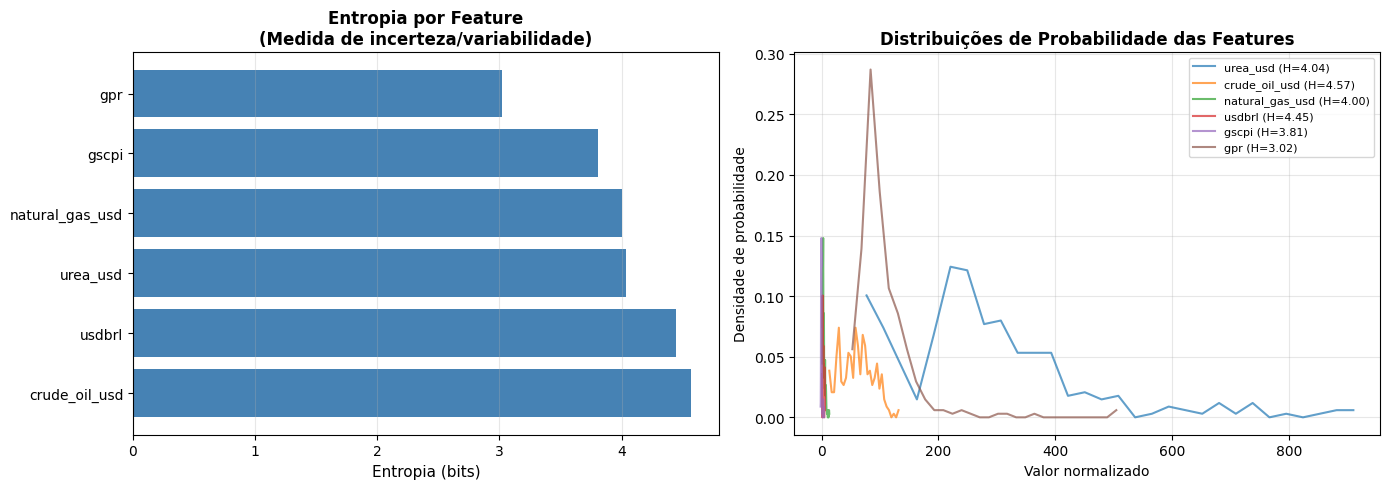

In [7]:
from scipy.stats import entropy

# Selecionar as features de interesse
features = ["urea_usd", "crude_oil_usd", "natural_gas_usd", "usdbrl", "gscpi", "gpr"]
df_features = df_merged[features].dropna()

# Calcular a entropia para cada feature
entropy_results = {}

for col in features:
    # Normalizar os dados para criar uma distribuição de probabilidade
    # Usando histograma para discretizar valores contínuos
    hist, bin_edges = np.histogram(df_features[col], bins=30, density=True)
    
    # Normalizar para soma = 1 (distribuição de probabilidade)
    hist = hist / hist.sum()
    
    # Remover bins vazios para evitar log(0)
    hist = hist[hist > 0]
    
    # Calcular entropia
    ent = entropy(hist, base=2)  # base=2 para bits, base=e para nats
    entropy_results[col] = ent

# Criar DataFrame com resultados
entropy_df = pd.DataFrame.from_dict(
    entropy_results, 
    orient='index', 
    columns=['entropy']
).sort_values('entropy', ascending=False)

print("=" * 60)
print("ENTROPIA DAS FEATURES (em bits)")
print("=" * 60)
print(entropy_df)
print("\nInterpretação:")
print("- Maior entropia = maior incerteza/variabilidade")
print("- Menor entropia = mais previsível/concentrada")

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras da entropia
ax1.barh(entropy_df.index, entropy_df['entropy'], color='steelblue')
ax1.set_xlabel('Entropia (bits)', fontsize=11)
ax1.set_title('Entropia por Feature\n(Medida de incerteza/variabilidade)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Distribuições normalizadas para comparação visual
for i, col in enumerate(features):
    hist, bin_edges = np.histogram(df_features[col], bins=30, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax2.plot(bin_centers, hist / hist.sum(), label=f"{col} (H={entropy_results[col]:.2f})", alpha=0.7)

ax2.set_xlabel('Valor normalizado', fontsize=10)
ax2.set_ylabel('Densidade de probabilidade', fontsize=10)
ax2.set_title('Distribuições de Probabilidade das Features', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8, loc='best')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Salvar resultados
# entropy_df.to_csv(TAB_DIR / "entropy_analysis.csv")
# print(f"\nResultados salvos em: {TAB_DIR / 'entropy_analysis.csv'}")

ÍNDICE DE SHANNON (ENTROPIA DE SHANNON) - em nats
                 shannon_index
crude_oil_usd         3.167094
usdbrl                3.081117
urea_usd              2.799721
natural_gas_usd       2.775433
gscpi                 2.640560
gpr                   2.092612

Interpretação do Índice de Shannon:
- Maior valor = maior diversidade/incerteza na distribuição
- Menor valor = maior concentração/previsibilidade
- Unidade: nats (logaritmo natural)
- Conversão: 1 nat ≈ 1.443 bits

ÍNDICE DE SHANNON - Comparação (nats vs bits)
                 shannon_index  shannon_bits
crude_oil_usd         3.167094      4.569151
usdbrl                3.081117      4.445113
urea_usd              2.799721      4.039143
natural_gas_usd       2.775433      4.004104
gscpi                 2.640560      3.809522
gpr                   2.092612      3.019001


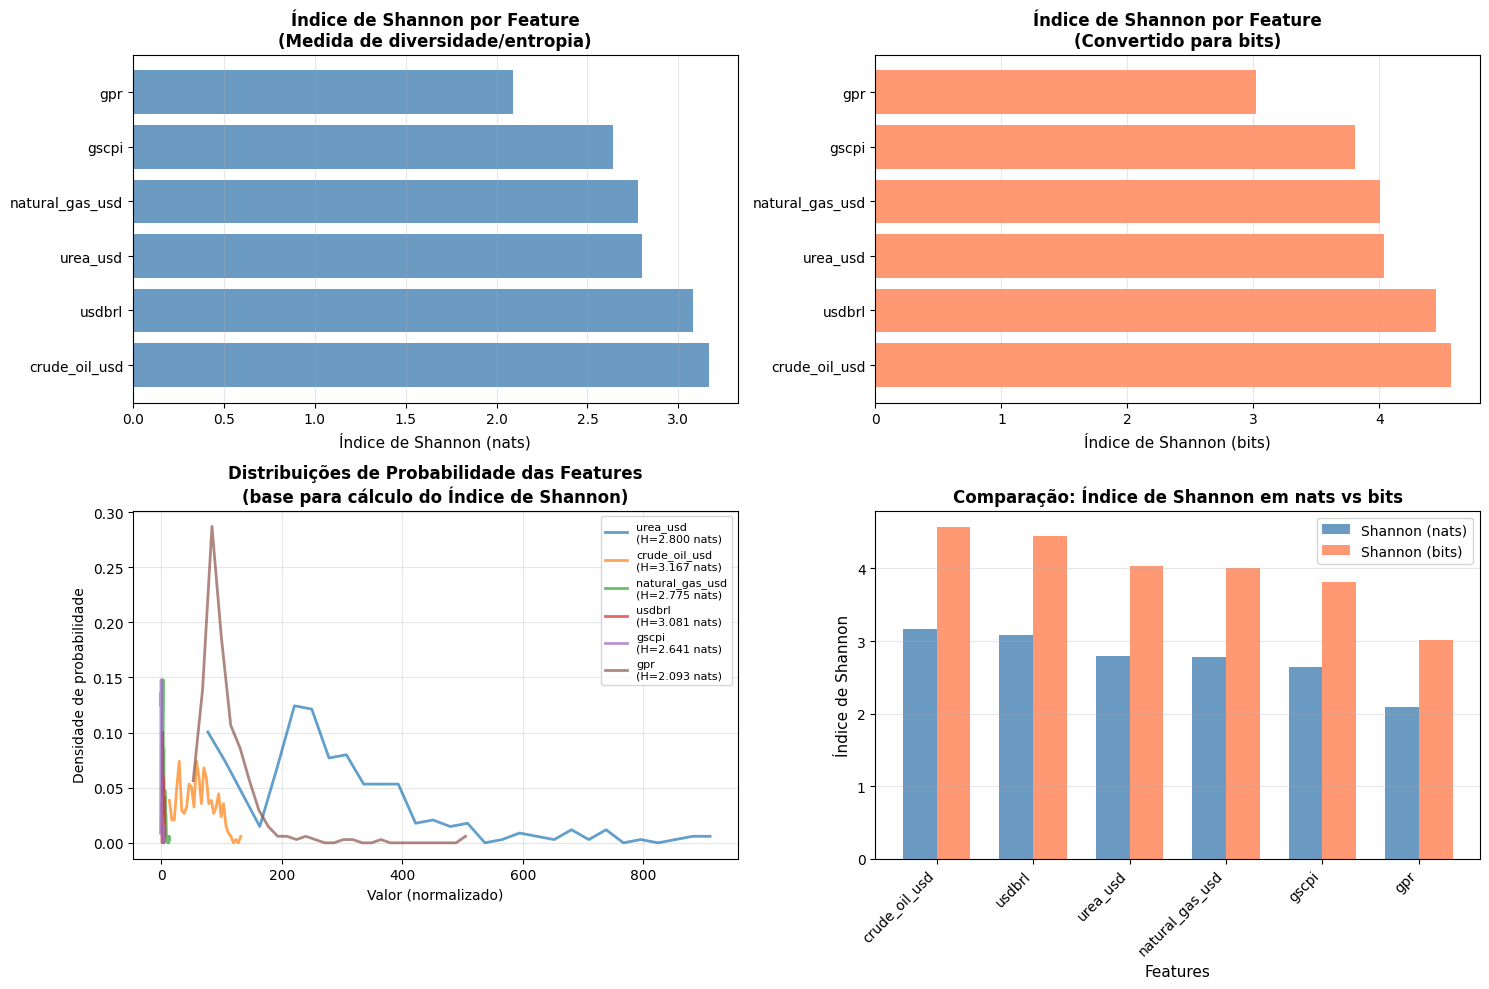


Resultados salvos em: c:\Users\Edmar - Trabalho\Documents\GitHub\urea-pricing-analysis\data\eda_outputs\tables\shannon_index_analysis.csv

ANÁLISE COMPARATIVA - ÍNDICE DE SHANNON

Feature mais diversa (maior entropia):
  → crude_oil_usd: 3.1671 nats

Feature mais concentrada (menor entropia):
  → gpr: 2.0926 nats

Razão max/min: 1.51x


In [7]:
from scipy.stats import entropy

# Selecionar as features de interesse
features = ["urea_usd", "crude_oil_usd", "natural_gas_usd", "usdbrl", "gscpi", "gpr"]
df_features = df_merged[features].dropna()

# Calcular o Índice de Shannon (Entropia de Shannon) para cada feature
shannon_results = {}

for col in features:
    # Normalizar os dados para criar uma distribuição de probabilidade
    # Usando histograma para discretizar valores contínuos
    hist, bin_edges = np.histogram(df_features[col], bins=30, density=True)
    
    # Normalizar para soma = 1 (distribuição de probabilidade)
    hist = hist / hist.sum()
    
    # Remover bins vazios para evitar log(0)
    hist = hist[hist > 0]
    
    # Calcular Índice de Shannon (entropia em nats - base natural)
    shannon_index = entropy(hist, base=np.e)  # base=e para nats (índice de Shannon clássico)
    shannon_results[col] = shannon_index

# Criar DataFrame com resultados
shannon_df = pd.DataFrame.from_dict(
    shannon_results, 
    orient='index', 
    columns=['shannon_index']
).sort_values('shannon_index', ascending=False)

print("=" * 70)
print("ÍNDICE DE SHANNON (ENTROPIA DE SHANNON) - em nats")
print("=" * 70)
print(shannon_df)
print("\nInterpretação do Índice de Shannon:")
print("- Maior valor = maior diversidade/incerteza na distribuição")
print("- Menor valor = maior concentração/previsibilidade")
print("- Unidade: nats (logaritmo natural)")
print("- Conversão: 1 nat ≈ 1.443 bits")

# Adicionar versão em bits para comparação
shannon_df['shannon_bits'] = shannon_df['shannon_index'] / np.log(2)

print("\n" + "=" * 70)
print("ÍNDICE DE SHANNON - Comparação (nats vs bits)")
print("=" * 70)
print(shannon_df)

# Visualização
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Gráfico de barras horizontal - Índice de Shannon (nats)
ax1.barh(shannon_df.index, shannon_df['shannon_index'], color='steelblue', alpha=0.8)
ax1.set_xlabel('Índice de Shannon (nats)', fontsize=11)
ax1.set_title('Índice de Shannon por Feature\n(Medida de diversidade/entropia)', 
              fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Gráfico de barras horizontal - Índice de Shannon (bits)
ax2.barh(shannon_df.index, shannon_df['shannon_bits'], color='coral', alpha=0.8)
ax2.set_xlabel('Índice de Shannon (bits)', fontsize=11)
ax2.set_title('Índice de Shannon por Feature\n(Convertido para bits)', 
              fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Distribuições de probabilidade (densidade)
for i, col in enumerate(features):
    hist, bin_edges = np.histogram(df_features[col], bins=30, density=True)
    hist_prob = hist / hist.sum()
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    ax3.plot(bin_centers, hist_prob, 
             label=f"{col}\n(H={shannon_results[col]:.3f} nats)", 
             alpha=0.7, linewidth=2)

ax3.set_xlabel('Valor (normalizado)', fontsize=10)
ax3.set_ylabel('Densidade de probabilidade', fontsize=10)
ax3.set_title('Distribuições de Probabilidade das Features\n(base para cálculo do Índice de Shannon)', 
              fontsize=12, fontweight='bold')
ax3.legend(fontsize=8, loc='best')
ax3.grid(alpha=0.3)

# 4. Comparação visual: nats vs bits
x_pos = np.arange(len(shannon_df))
width = 0.35

ax4.bar(x_pos - width/2, shannon_df['shannon_index'], width, 
        label='Shannon (nats)', color='steelblue', alpha=0.8)
ax4.bar(x_pos + width/2, shannon_df['shannon_bits'], width, 
        label='Shannon (bits)', color='coral', alpha=0.8)

ax4.set_xlabel('Features', fontsize=11)
ax4.set_ylabel('Índice de Shannon', fontsize=11)
ax4.set_title('Comparação: Índice de Shannon em nats vs bits', 
              fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(shannon_df.index, rotation=45, ha='right')
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Salvar resultados
shannon_df.to_csv(TAB_DIR / "shannon_index_analysis.csv")
print(f"\n{'='*70}")
print(f"Resultados salvos em: {TAB_DIR / 'shannon_index_analysis.csv'}")
print(f"{'='*70}")

# Análise estatística adicional
print("\n" + "=" * 70)
print("ANÁLISE COMPARATIVA - ÍNDICE DE SHANNON")
print("=" * 70)
print(f"\nFeature mais diversa (maior entropia):")
print(f"  → {shannon_df.index[0]}: {shannon_df.iloc[0]['shannon_index']:.4f} nats")
print(f"\nFeature mais concentrada (menor entropia):")
print(f"  → {shannon_df.index[-1]}: {shannon_df.iloc[-1]['shannon_index']:.4f} nats")
print(f"\nRazão max/min: {shannon_df.iloc[0]['shannon_index'] / shannon_df.iloc[-1]['shannon_index']:.2f}x")
print("=" * 70)

## Cobertura temporal por dataset:
---
Deixar explícito quais fontes cobrem quais períodos, verificando se existe sobreposição suficiente para análises conjuntas. É um slide ótimo para justificar por que alguns modelos/insights só fazem sentido a partir de certo ano (por exemplo, se um índice começa muito depois).

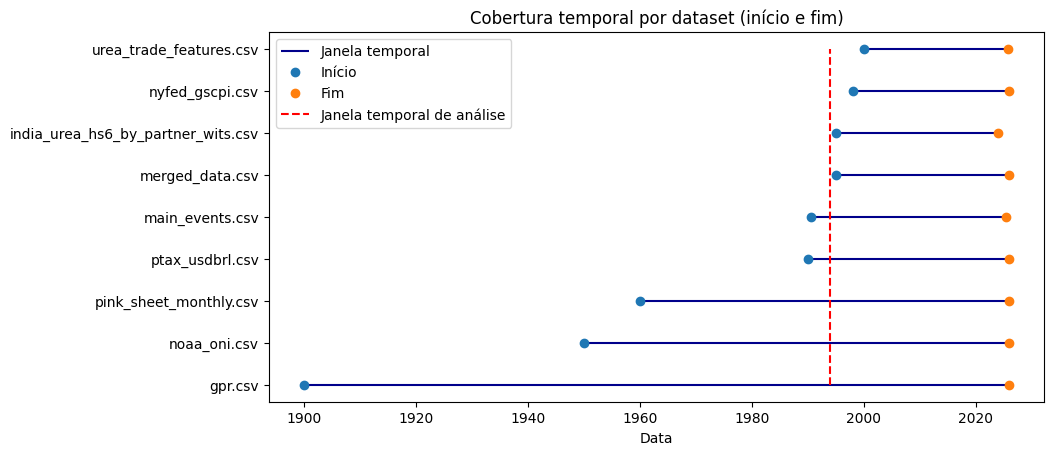

In [14]:
fig = plt.figure(figsize=(10, 4.8))
ax = fig.add_subplot(111)

timeline = overview.dropna(subset=["min_date", "max_date"]).copy()
timeline = timeline.sort_values("min_date")
y = np.arange(len(timeline))
ax.hlines(y=y, xmin=timeline["min_date"], xmax=timeline["max_date"], label="Janela temporal", color="darkblue")
ax.plot(timeline["min_date"], y, marker="o", linestyle="None", label="Início")
ax.plot(timeline["max_date"], y, marker="o", linestyle="None", label="Fim")
ax.vlines(pd.Timestamp("1994-01-01"), ymin=0, ymax=len(timeline)-1, color="red", linestyle="--", label="Janela temporal de análise")
ax.set_yticks(y)
ax.set_yticklabels(timeline["dataset"])
ax.set_title("Cobertura temporal por dataset (início e fim)")
ax.set_xlabel("Data")
ax.legend()

plt.show()

## Mapa de dados faltantes:
---
Serve para enxergar rapidamente se os faltantes estão concentrados em determinados períodos (ex.: início da série) ou em variáveis específicas. Ajuda em decisões como recorte temporal para a análise, escolha de imputação, ou até a exclusão de variáveis pouco confiáveis.

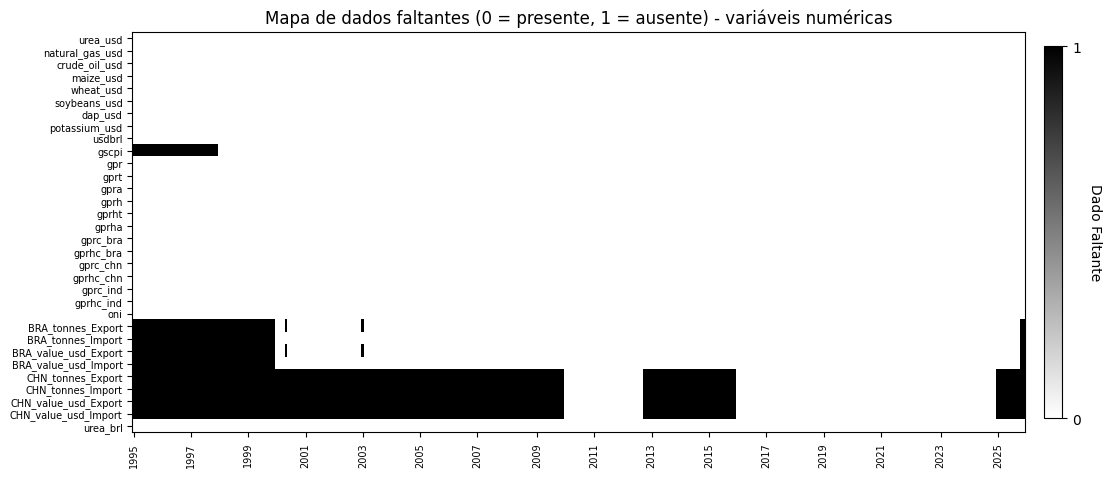

In [17]:
num_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
heat = df_merged[num_cols].isna().astype(int).to_numpy().T

fig, ax = plt.subplots(figsize=(12, 5.2))
im = ax.imshow(heat, aspect="auto", interpolation="nearest", cmap="binary", vmin=0, vmax=1)
ax.set_title("Mapa de dados faltantes (0 = presente, 1 = ausente) - variáveis numéricas")
ax.set_yticks(np.arange(len(num_cols)))
ax.set_yticklabels(num_cols, fontsize=7)

dates = df_merged.index.to_numpy()
if len(dates) > 0:
    years = pd.DatetimeIndex(dates).year
    tick_idx = np.where((pd.DatetimeIndex(dates).month == 1))[0]
    ax.set_xticks(tick_idx[::2] if len(tick_idx) > 25 else tick_idx)
    ax.set_xticklabels(pd.DatetimeIndex(dates)[ax.get_xticks()].year, rotation=90, fontsize=7)

cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02, ticks=[0, 1])
cbar.set_label("Dado Faltante", rotation=270, labelpad=15)

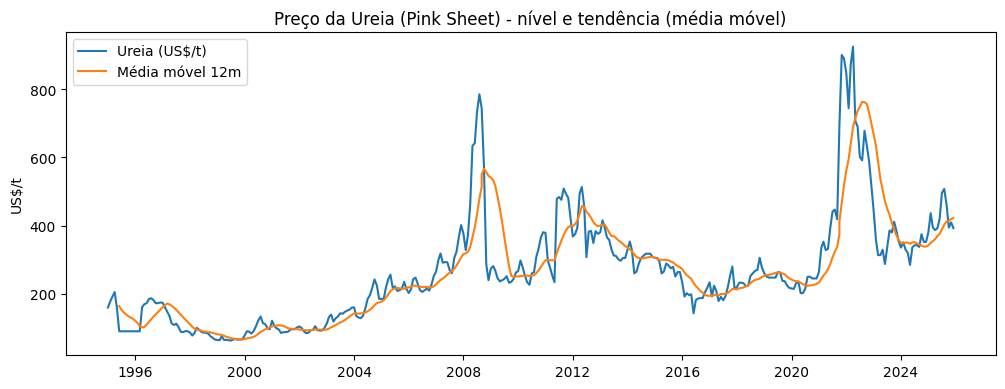

In [18]:
s_urea = df_merged[UREA_COL].astype(float)

fig = plt.figure(figsize=(12, 4.2))
ax = fig.add_subplot(111)
ax.plot(s_urea.index, s_urea.values, label="Ureia (US$/t)")
ax.plot(s_urea.index, s_urea.rolling(12, min_periods=6).mean().values, label="Média móvel 12m")
ax.set_title("Preço da Ureia (Pink Sheet) - nível e tendência (média móvel)")
ax.set_ylabel("US$/t")
ax.legend(loc="best")

plt.show()

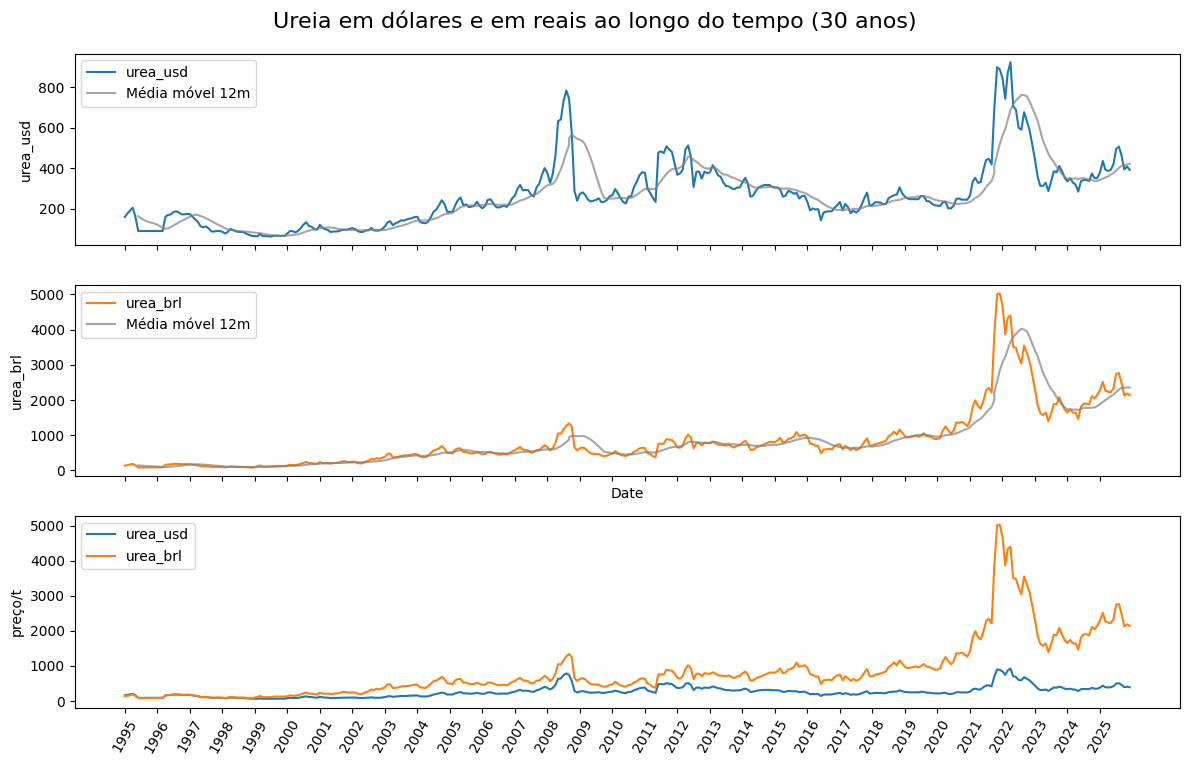

In [19]:
import matplotlib.dates as mdates

feature1 = UREA_COL
feature2 = 'urea_brl'

tmp_df = df_merged[df_merged.index >= pd.to_datetime("1995-01-01")].copy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
if feature1 in tmp_df.columns:
    ax1.plot(tmp_df.index, tmp_df[feature1], color='C0', label=feature1)
    ax1.plot(tmp_df.index, tmp_df[feature1].rolling(12, min_periods=6).mean().values, color='gray', label="Média móvel 12m", alpha=0.7)
    ax1.set_ylabel(feature1)
    ax1.legend(loc='upper left')
if feature2 in tmp_df.columns:
    ax2.plot(tmp_df.index, tmp_df[feature2], color='C1', label=feature2)
    ax2.plot(tmp_df.index, tmp_df[feature2].rolling(12, min_periods=6).mean().values, color='gray', label="Média móvel 12m", alpha=0.7)
    ax2.set_ylabel(feature2)
    ax2.legend(loc='upper left')
if feature1 in tmp_df.columns and feature2 in tmp_df.columns:
    ax3.plot(tmp_df.index, tmp_df[feature1], color='C0', label=feature1)
    ax3.plot(tmp_df.index, tmp_df[feature2], color='C1', label=feature2)
    ax3.legend(loc='upper left')
    ax3.set_ylabel('preço/t')

    years = pd.date_range(tmp_df.index.values.min(), tmp_df.index.values.max(), freq="YS")
    ax3.set_xticks(years)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax3.tick_params(axis="x", rotation=60)

ax2.set_xlabel('Date')
fig.suptitle(f'Ureia em dólares e em reais ao longo do tempo (30 anos)', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

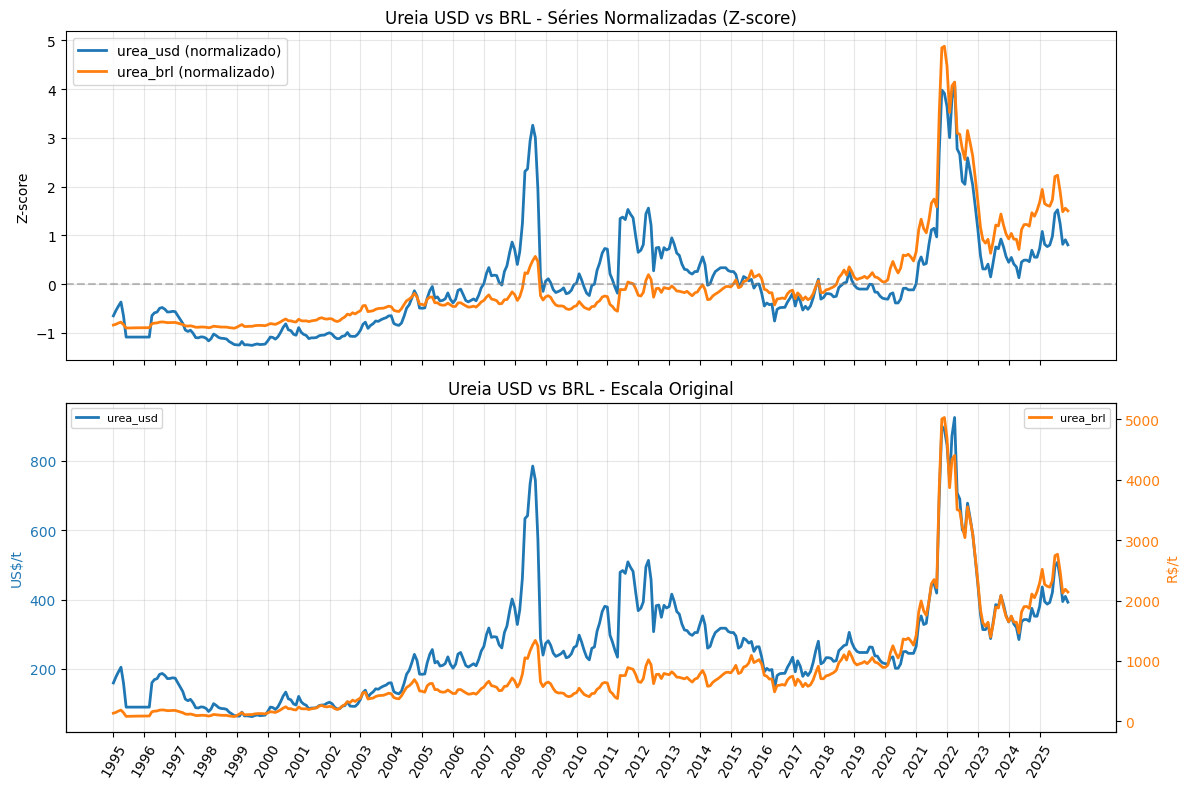

In [20]:
import matplotlib.dates as mdates

feature1 = 'urea_usd'
feature2 = 'urea_brl'

tmp_df = df_merged[df_merged.index >= pd.to_datetime("1995-01-01")].copy()

# Normalizar com z-score
tmp_df['urea_usd_norm'] = (tmp_df[feature1] - tmp_df[feature1].mean()) / tmp_df[feature1].std()
tmp_df['urea_brl_norm'] = (tmp_df[feature2] - tmp_df[feature2].mean()) / tmp_df[feature2].std()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Gráfico 1: Séries normalizadas
ax1.plot(tmp_df.index, tmp_df['urea_usd_norm'], color='C0', label='urea_usd (normalizado)', linewidth=2)
ax1.plot(tmp_df.index, tmp_df['urea_brl_norm'], color='C1', label='urea_brl (normalizado)', linewidth=2)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.set_ylabel('Z-score')
ax1.set_title('Ureia USD vs BRL - Séries Normalizadas (Z-score)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Gráfico 2: Escala original (para referência)
ax2_right = ax2.twinx()
ax2.plot(tmp_df.index, tmp_df[feature1], color='C0', label='urea_usd', linewidth=2)
ax2_right.plot(tmp_df.index, tmp_df[feature2], color='C1', label='urea_brl', linewidth=2)
ax2.set_ylabel('US$/t', color='C0')
ax2_right.set_ylabel('R$/t', color='C1')
ax2.tick_params(axis='y', labelcolor='C0')
ax2_right.tick_params(axis='y', labelcolor='C1')
ax2.set_title('Ureia USD vs BRL - Escala Original')
ax2.legend(loc='upper left', fontsize=8)
ax2_right.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

years = pd.date_range(tmp_df.index.values.min(), tmp_df.index.values.max(), freq="YS")
ax2.set_xticks(years)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax2.tick_params(axis="x", rotation=60)

fig.tight_layout()
plt.show()

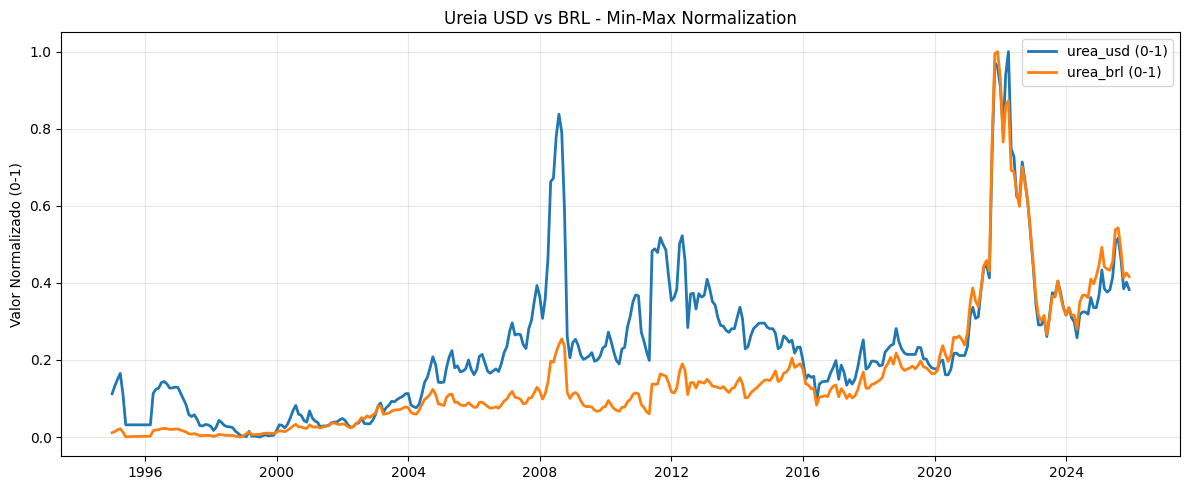

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
tmp_df['urea_usd_norm'] = scaler.fit_transform(tmp_df[[feature1]])
tmp_df['urea_brl_norm'] = scaler.fit_transform(tmp_df[[feature2]])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tmp_df.index, tmp_df['urea_usd_norm'], color='C0', label='urea_usd (0-1)', linewidth=2)
ax.plot(tmp_df.index, tmp_df['urea_brl_norm'], color='C1', label='urea_brl (0-1)', linewidth=2)
ax.set_ylabel('Valor Normalizado (0-1)')
ax.set_title('Ureia USD vs BRL - Min-Max Normalization')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

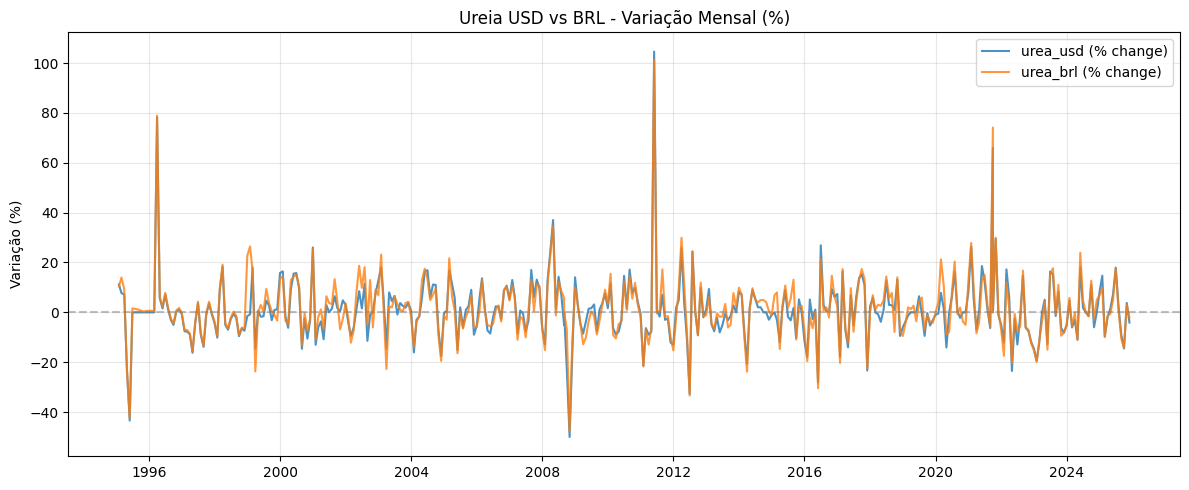

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tmp_df.index, tmp_df[feature1].pct_change() * 100, color='C0', label='urea_usd (% change)', linewidth=1.5, alpha=0.8)
ax.plot(tmp_df.index, tmp_df[feature2].pct_change() * 100, color='C1', label='urea_brl (% change)', linewidth=1.5, alpha=0.8)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('Variação (%)')
ax.set_title('Ureia USD vs BRL - Variação Mensal (%)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

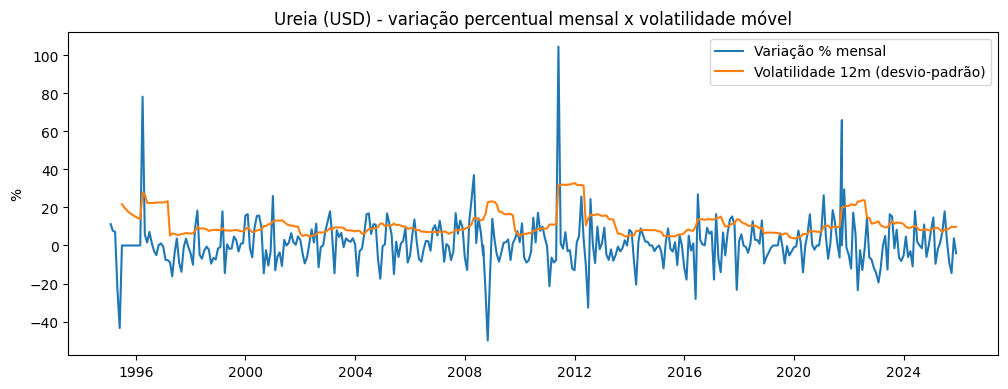

In [23]:
s_urea = df_merged[UREA_COL].astype(float)

ret = s_urea.pct_change() * 100
vol12 = ret.rolling(12, min_periods=6).std()

fig = plt.figure(figsize=(12, 4.2))
ax = fig.add_subplot(111)
ax.plot(ret.index, ret.values, label="Variação % mensal")
ax.plot(vol12.index, vol12.values, label="Volatilidade 12m (desvio-padrão)")
ax.set_title("Ureia (USD) - variação percentual mensal x volatilidade móvel")
ax.set_ylabel("%")
ax.legend(loc="best")

plt.show()

C:\Users\Edmar - Trabalho\AppData\Local\Temp\ipykernel_6388\910779344.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_by_month, labels=[str(m) for m in range(1, 13)], showfliers=False)


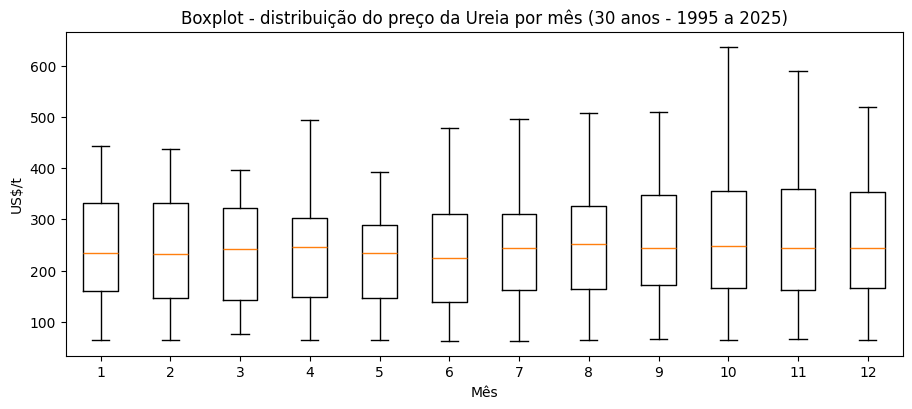

In [24]:
s_urea = s_urea[s_urea.index >= pd.to_datetime("1995-01-01")]

tmp = pd.DataFrame({"date": s_urea.index, "urea": s_urea.values})
tmp["month"] = tmp["date"].dt.month
data_by_month = [tmp.loc[tmp["month"] == m, "urea"].dropna().values for m in range(1, 13)]

fig = plt.figure(figsize=(10.8, 4.2))
ax = fig.add_subplot(111)
ax.boxplot(data_by_month, labels=[str(m) for m in range(1, 13)], showfliers=False)
ax.set_title("Boxplot - distribuição do preço da Ureia por mês (30 anos - 1995 a 2025)")
ax.set_xlabel("Mês")
ax.set_ylabel("US$/t")

plt.show()

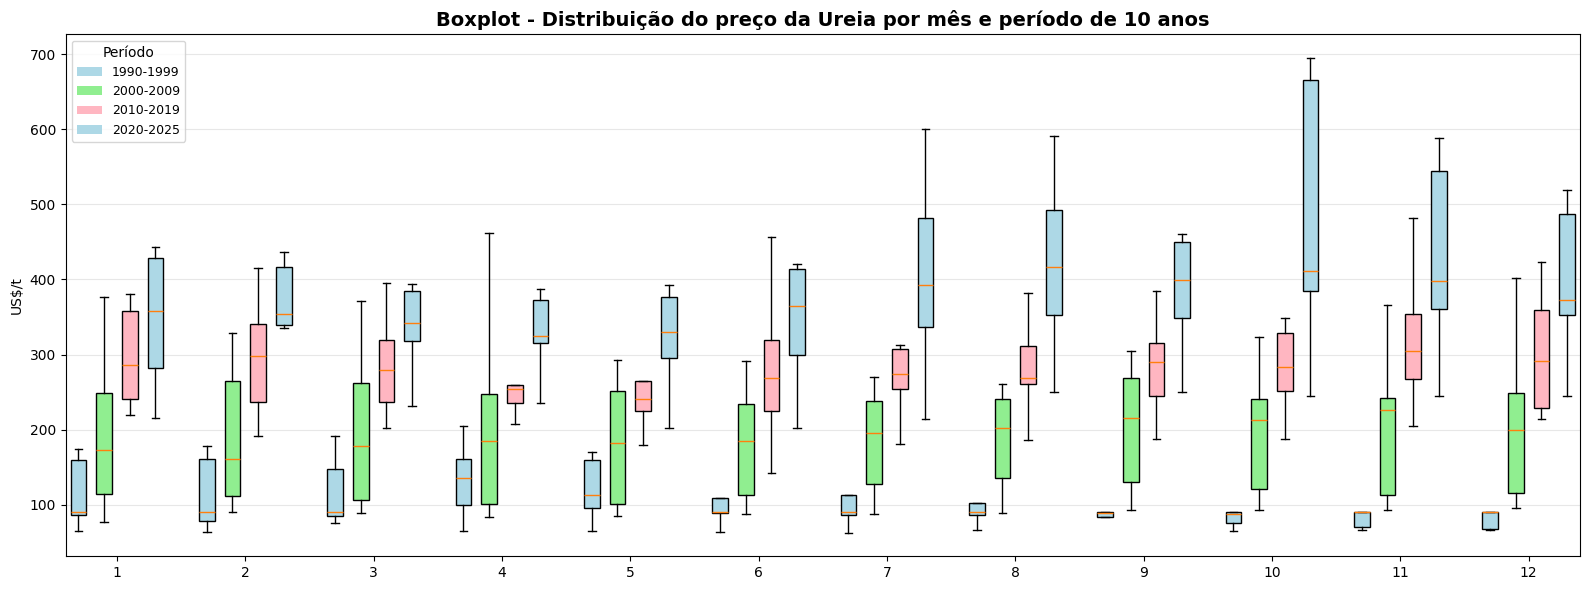

In [25]:
tmp = pd.DataFrame({"date": s_urea.index, "urea": s_urea.values})
tmp["month"] = tmp["date"].dt.month
tmp["year"] = tmp["date"].dt.year
tmp["year_group"] = (tmp["year"] // 10) * 10

year_groups = sorted(tmp["year_group"].unique())
year_labels = [f"{yr}-{yr+9}" if yr + 9 <= tmp["year"].max() else f"{yr}-{tmp['year'].max()}" for yr in year_groups]

fig, ax = plt.subplots(figsize=(16, 6))

# Posições para os boxplots (mês, depois período)
positions = []
data_to_plot = []
colors_list = []
month_to_positions = {m: [] for m in range(1, 13)}  # Mapear mês para posições
pos = 1

color_palette = ['lightblue', 'lightgreen', 'lightpink']

for month in range(1, 13):
    for idx, year_group in enumerate(year_groups):
        data = tmp.loc[(tmp["year_group"] == year_group) & (tmp["month"] == month), "urea"].dropna().values
        if len(data) > 0:
            data_to_plot.append(data)
            positions.append(pos)
            colors_list.append(color_palette[idx % len(color_palette)])
            month_to_positions[month].append(pos)  # Guardar posição para este mês
            pos += 1
    pos += 1  # Espaço entre meses

bp = ax.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True, showfliers=False)

# Colorir os boxplots
for patch, color in zip(bp['boxes'], colors_list):
    patch.set_facecolor(color)

# Adicionar labels para os meses
month_positions = []
month_labels = []
for month in range(1, 13):
    if month_to_positions[month]:  # Se há dados para este mês
        avg_pos = np.mean(month_to_positions[month])
        month_positions.append(avg_pos)
        month_labels.append(str(month))

ax.set_xticks(month_positions)
ax.set_xticklabels(month_labels)
ax.set_ylabel("US$/t")
ax.set_title("Boxplot - Distribuição do preço da Ureia por mês e período de 10 anos", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Legenda com cores para períodos
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_palette[i % len(color_palette)], label=year_labels[i]) 
                   for i in range(len(year_groups))]
ax.legend(handles=legend_elements, loc='upper left', title='Período', fontsize=9)

plt.tight_layout()
plt.show()

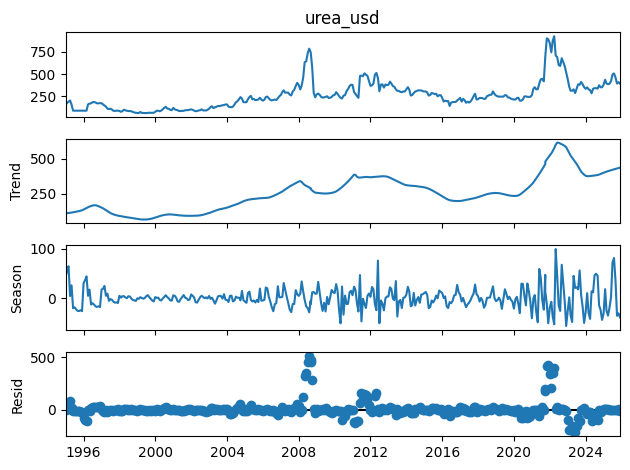

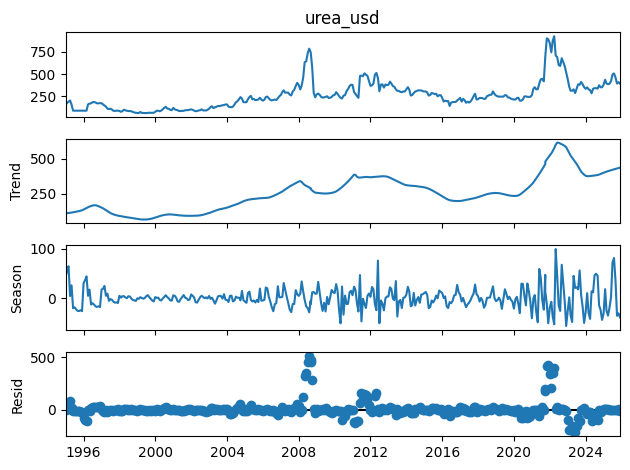

In [28]:
stl.plot()

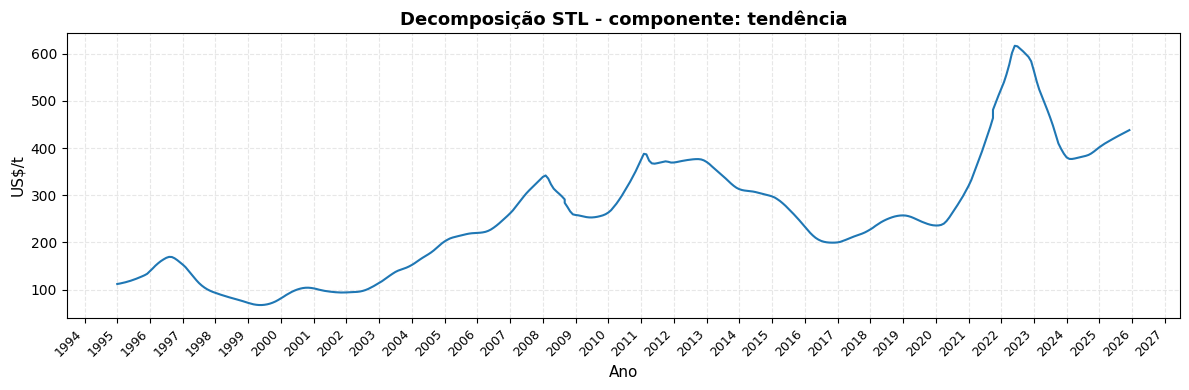

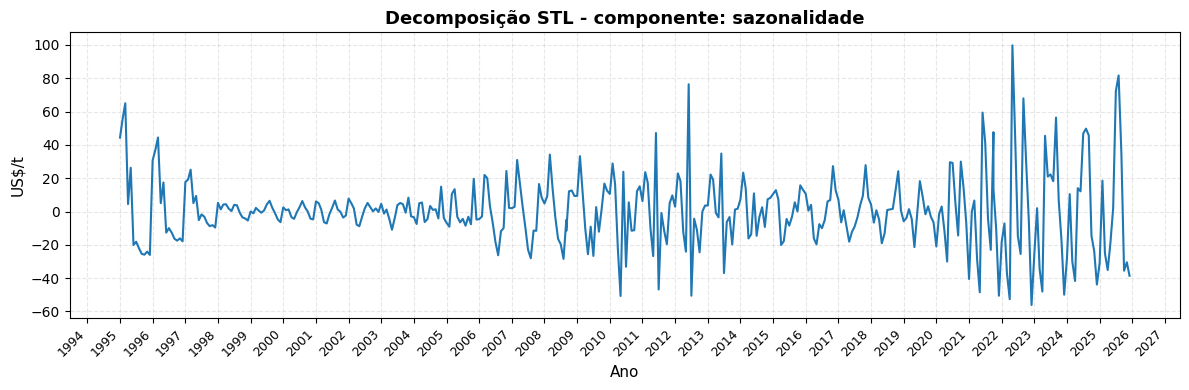

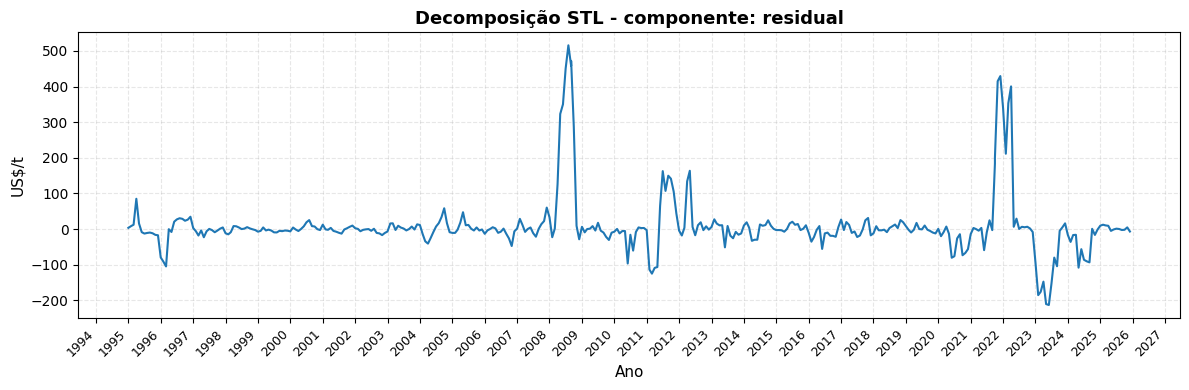

In [31]:
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates

stl_series = s_urea.dropna()
stl = STL(stl_series, period=12, robust=True).fit()

translations = {
    "trend": "tendência",
    "seasonal": "sazonalidade",
    "resid": "residual",
}

for comp_name, comp_series in [
    ("trend", stl.trend),
    ("seasonal", stl.seasonal),
    ("resid", stl.resid),
]:
    fig, ax = plt.subplots(figsize=(12, 4.0))
    ax.plot(comp_series.index, comp_series.values, linewidth=1.5)
    ax.set_title(f"Decomposição STL - componente: {translations[comp_name]}", fontsize=13, fontweight='bold')
    ax.set_ylabel("US$/t", fontsize=11)
    ax.set_xlabel("Ano", fontsize=11)
    
    # Configurar anos no eixo X
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Rotação e alinhamento
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)
    
    # Grid para melhor leitura
    ax.grid(True, alpha=0.3, linestyle='--')
    
    fig.tight_layout()

plt.show()

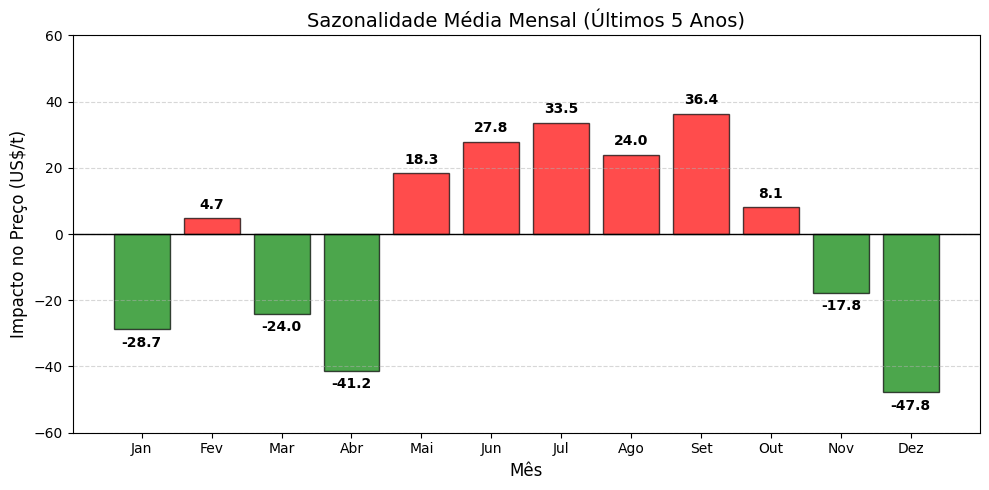

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# 1. Extrair a série sazonal do seu objeto STL já treinado
seasonal = stl.seasonal

# 2. Filtrar apenas os últimos 5 anos de dados
# Pega a última data disponível e subtrai 5 anos
data_corte = seasonal.index.max() - pd.DateOffset(years=5)
seasonal_recent = seasonal[seasonal.index > data_corte]

# 3. Agrupar por mês e calcular a média da sazonalidade para cada mês
# O index.month retorna 1 para Jan, 2 para Fev, etc.
monthly_avg = seasonal_recent.groupby(seasonal_recent.index.month).mean()

# Criar nomes dos meses para o eixo X
month_names = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
               'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# 4. Plotar o Gráfico de Barras
fig, ax = plt.subplots(figsize=(10, 5))

# Criar cores condicionais: Verde para preço baixo (compra), Vermelho para preço alto
colors = ['green' if x < 0 else 'red' for x in monthly_avg.values]

bars = ax.bar(month_names, monthly_avg.values, color=colors, alpha=0.7, edgecolor='black')

# Estilização
ax.set_title("Sazonalidade média mensal (últimos 5 anos)", fontsize=14)
ax.set_ylabel("Impacto no Preço (US$/t)", fontsize=12)
ax.set_xlabel("Mês", fontsize=12)
ax.axhline(0, color='black', linewidth=1, linestyle='-') # Linha zero
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Adicionar o valor exato em cima/baixo das barras
for bar in bars:
    height = bar.get_height()
    offset = 2 if height > 0 else -2  # Ajuste da posição do texto
    ax.text(bar.get_x() + bar.get_width()/2., height + offset,
            f'{height:.1f}',
            ha='center', va='bottom' if height > 0 else 'top', 
            fontsize=10, fontweight='bold', color='black')

ax.set_ylim(-60, 60)

plt.tight_layout()
plt.show()

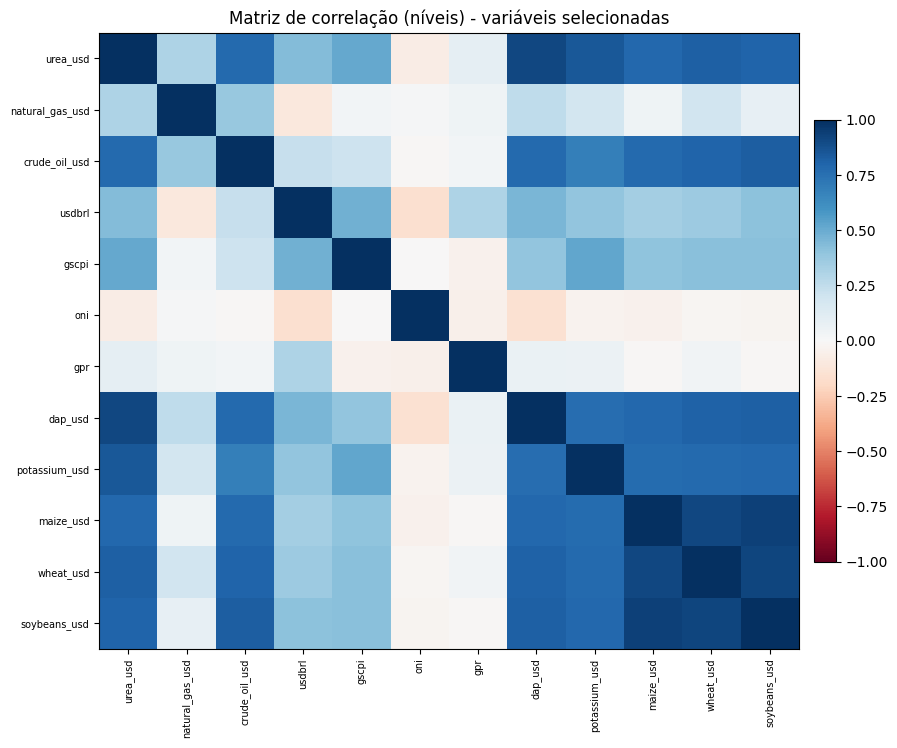

In [38]:
key_cols = [
    "urea_usd",
    "natural_gas_usd",
    "crude_oil_usd",
    "usdbrl",
    "gscpi",
    "oni",
    "gpr",
    "dap_usd",
    "potassium_usd",
    "maize_usd",
    "wheat_usd",
    "soybeans_usd",
]
key_cols = [c for c in key_cols if c in df_merged.columns]
corr = df_merged[key_cols].corr(numeric_only=True)

fig = plt.figure(figsize=(9.5, 8.0))
ax = fig.add_subplot(111)
im = ax.imshow(corr.values, interpolation="nearest", aspect="auto", cmap="RdBu", vmin=-1, vmax=1)
ax.set_title("Matriz de correlação (níveis) - variáveis selecionadas")
ax.set_xticks(np.arange(len(key_cols)))
ax.set_yticks(np.arange(len(key_cols)))
ax.set_xticklabels(key_cols, rotation=90, fontsize=7)
ax.set_yticklabels(key_cols, fontsize=7)
fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)

In [47]:
df_merged.columns

Index(['urea_usd', 'natural_gas_usd', 'crude_oil_usd', 'maize_usd',
       'wheat_usd', 'soybeans_usd', 'dap_usd', 'potassium_usd', 'usdbrl',
       'gscpi', 'gpr', 'gprt', 'gpra', 'gprh', 'gprht', 'gprha', 'gprc_bra',
       'gprhc_bra', 'gprc_chn', 'gprhc_chn', 'gprc_ind', 'gprhc_ind', 'oni',
       'period', 'event', 'BRA_tonnes_Export', 'BRA_tonnes_Import',
       'BRA_value_usd_Export', 'BRA_value_usd_Import', 'CHN_tonnes_Export',
       'CHN_tonnes_Import', 'CHN_value_usd_Export', 'CHN_value_usd_Import',
       'urea_brl'],
      dtype='object')

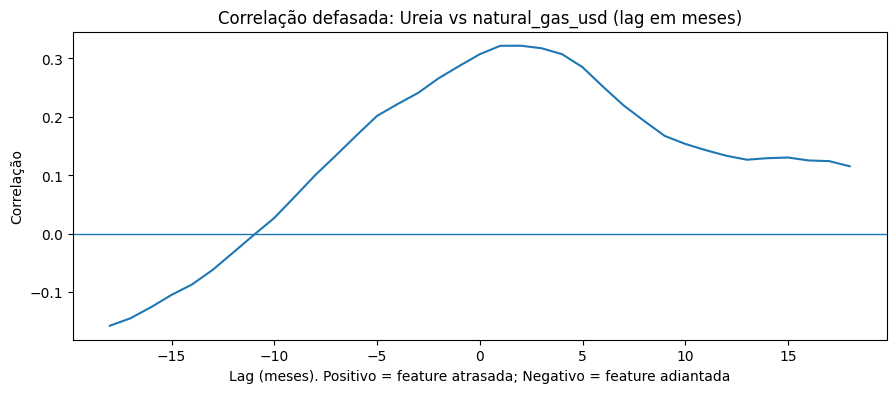

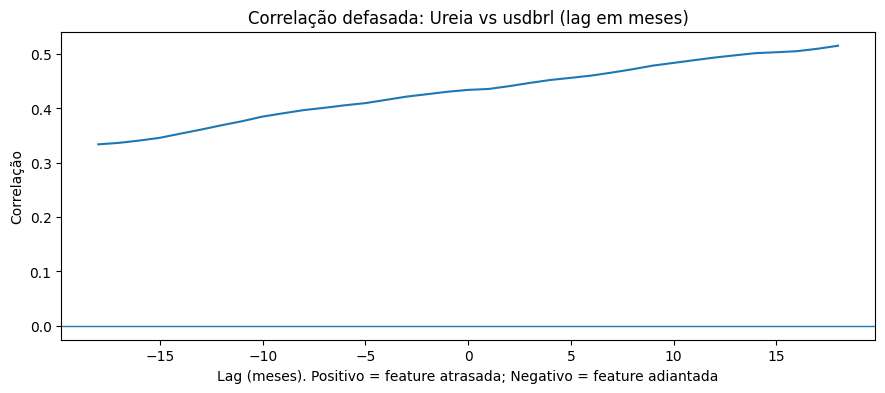

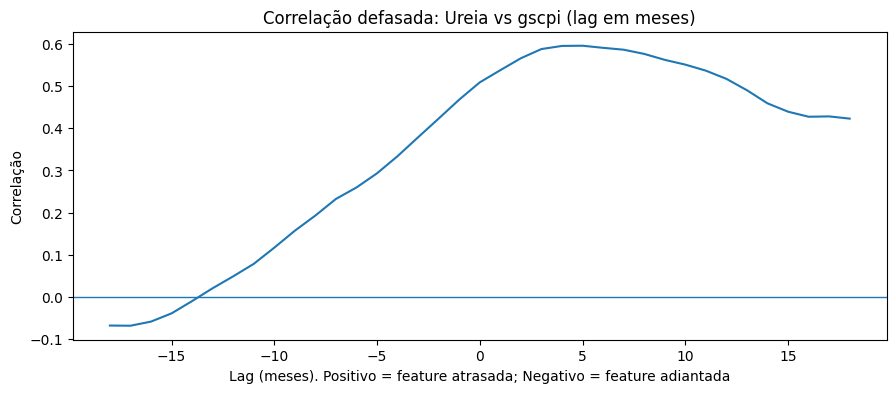

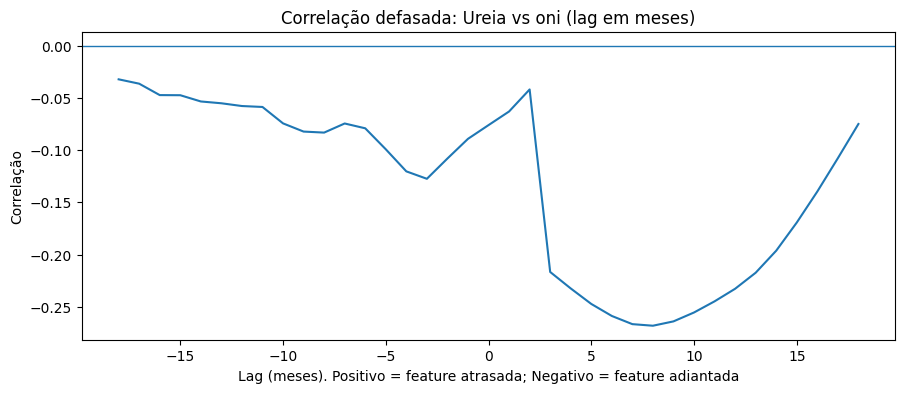

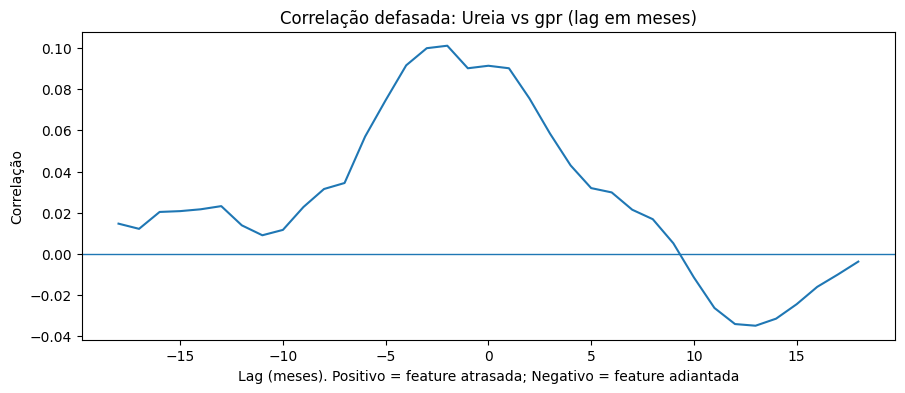

In [48]:
import re

def lagged_corr(target: pd.Series, feature: pd.Series, max_lag: int = 24):
    # corr(target_t, feature_{t-lag}) for lag in [-max_lag, +max_lag]
    lags = np.arange(-max_lag, max_lag + 1)
    out = []
    for lag in lags:
        shifted = feature.shift(lag)
        d = pd.concat([target, shifted], axis=1).dropna()
        out.append(d.iloc[:, 0].corr(d.iloc[:, 1]) if len(d) > 5 else np.nan)
    return pd.Series(out, index=lags, name="corr")

lag_features = ["natural_gas_usd", "crude_oil_wti_usd", "usdbrl", "gscpi", "oni", "gpr"]
lag_summ = []

for feat in lag_features:
    if feat not in df_merged.columns:
        continue
    lc = lagged_corr(s_urea, df_merged[feat].astype(float), max_lag=18)
    best_lag = int(lc.abs().idxmax()) if lc.dropna().size else np.nan
    best_corr = float(lc.loc[best_lag]) if not np.isnan(best_lag) else np.nan
    lag_summ.append({"feature": feat, "best_lag_months": best_lag, "corr_at_best_lag": best_corr})
    lc.to_csv(TAB_DIR / f"09_lagged_corr_{re.sub(r'[^a-zA-Z0-9]+','_',feat).lower()}.csv")

    fig = plt.figure(figsize=(10.5, 4.0))
    ax = fig.add_subplot(111)
    ax.plot(lc.index, lc.values)
    ax.axhline(0, linewidth=1)
    ax.set_title(f"Correlação defasada: Ureia vs {feat} (lag em meses)")
    ax.set_xlabel("Lag (meses). Positivo = feature atrasada; Negativo = feature adiantada")
    ax.set_ylabel("Correlação")

plt.show()

In [49]:
df_merged[["urea_usd", "crude_oil_usd", "natural_gas_usd", "usdbrl", "gscpi", "gpr"]].corr()

,urea_usd,crude_oil_usd,natural_gas_usd,usdbrl,gscpi,gpr
urea_usd,1.000000,0.778324,0.307311,0.434116,0.508591,0.091377
crude_oil_usd,0.778324,1.000000,0.379556,0.234365,0.203707,0.030372
natural_gas_usd,0.307311,0.379556,1.000000,-0.101704,0.026299,0.039525
usdbrl,0.434116,0.234365,-0.101704,1.000000,0.483753,0.311633
gscpi,0.508591,0.203707,0.026299,0.483753,1.000000,-0.043411
gpr,0.091377,0.030372,0.039525,0.311633,-0.043411,1.000000


In [ ]:
from scipy.stats import entropy

entropy

ValueError: cannot reindex on an axis with duplicate labels

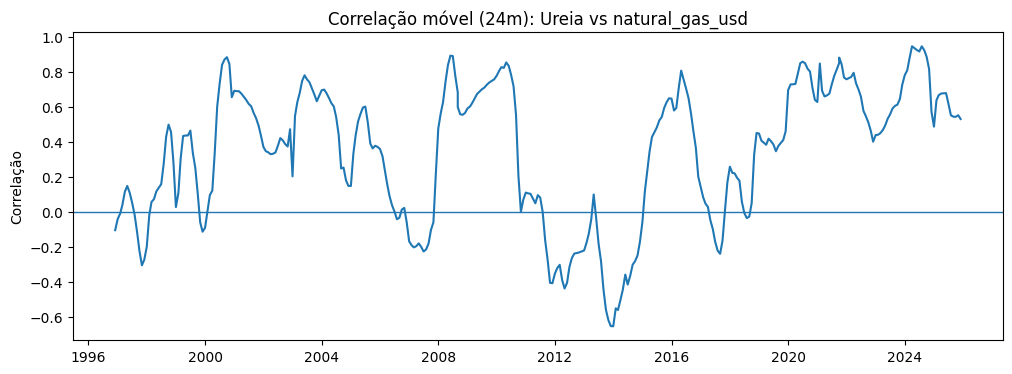

In [31]:
def rolling_corr(a: pd.Series, b: pd.Series, window: int = 12):
    d = pd.concat([a, b], axis=1).dropna()
    return d.iloc[:, 0].rolling(window).corr(d.iloc[:, 1])

for feat in ["natural_gas_usd", "crude_oil_usd", "usdbrl", "gscpi"]:
    if feat not in df_merged.columns:
        continue
    rc = rolling_corr(s_urea, df_merged[feat].astype(float), window=24)

    fig = plt.figure(figsize=(12, 4.0))
    ax = fig.add_subplot(111)
    ax.plot(rc.index, rc.values)
    ax.axhline(0, linewidth=1)
    ax.set_title(f"Correlação móvel (24m): Ureia vs {feat}")
    ax.set_ylabel("Correlação")

In [ ]:
norm_cols = ["Urea  ($/mt)", "Natural gas, US ($/mmbtu)", "Crude oil, WTI ($/bbl)", "usdbrl", "gscpi", "gpr"]
norm_cols = [c for c in norm_cols if c in df_merged.columns]
norm_df = df_merged[norm_cols].apply(zscore)

fig = plt.figure(figsize=(12, 4.6))
ax = fig.add_subplot(111)
for c in norm_cols:
    ax.plot(norm_df.index, norm_df[c].values, label=c)
ax.set_title("Séries normalizadas (z-score) para comparar movimentos (sem escala)")
ax.set_ylabel("z-score")
ax.legend(loc="best", fontsize=7)

In [ ]:
if "usdbrl" in df_merged.columns:
    urea_brl = df_merged["urea_usd"].astype(float) * df_merged["usdbrl"].astype(float)
    df_merged["urea_brl"] = urea_brl

    fig = plt.figure(figsize=(12, 4.2))
    ax = fig.add_subplot(111)
    ax.plot(urea_brl.index, urea_brl.values, label="Ureia (R$/t)")
    ax.plot(urea_brl.index, urea_brl.rolling(12, min_periods=6).mean().values, label="Média móvel 12m")
    ax.set_title("Custo implícito no Brasil: Ureia (US$/t) * câmbio (USD/BRL)")
    ax.set_ylabel("R$/t")
    ax.legend(loc="best")

In [ ]:
events = df_events.dropna(subset=["date", "event"]).copy()
events = events.sort_values("date")
# Compute event-month return
event_impact = []
for _, row in events.iterrows():
    d = row["date"]
    if d not in df_merged.index:
        continue
    r = float(ret.loc[d]) if d in ret.index else np.nan
    p = float(s_urea.loc[d]) if d in s_urea.index else np.nan
    event_impact.append({"date": d, "event": row["event"], "urea_usd_mt": p, "urea_mom_pct": r})

event_impact_df = pd.DataFrame(event_impact).sort_values("date")
event_impact_df.to_csv(TAB_DIR / "13_event_impact_table.csv", index=False)

# Plot with markers for events (no annotation flood)
fig = plt.figure(figsize=(12, 4.5))
ax = fig.add_subplot(111)
ax.plot(s_urea.index, s_urea.values, label="urea_usd")
ev_dates = event_impact_df["date"]
ev_vals = df_merged.loc[ev_dates, "urea_usd"].astype(float).values if len(ev_dates) else np.array([])
ax.scatter(ev_dates, ev_vals, label="Eventos (mês)", s=15)
ax.set_title("Ureia com marcação de meses com eventos históricos (main_events)")
ax.set_ylabel("US$/t")
ax.legend(loc="best")

In [ ]:
trade = df_trade.copy()
trade["flowDesc"] = trade["flowDesc"].astype(str)

def plot_trade_country(country_prefix: str, flow: str, y_col: str, title: str, filename: str):
    col = f"{country_prefix}_{y_col}"
    if col not in trade.columns:
        return
    d = trade.loc[trade["flowDesc"] == flow, ["date", col]].copy()
    d = d.dropna().sort_values("date").set_index("date")
    # join urea price for overlapping range
    joined = d.join(s_urea.rename("urea_price"), how="left")
    fig = plt.figure(figsize=(12, 4.3))
    ax = fig.add_subplot(111)
    ax.plot(joined.index, joined[col].values, label=f"{country_prefix} {flow} {y_col}")
    ax2 = ax.twinx()
    ax2.plot(joined.index, joined["urea_price"].values, label="urea_usd")
    ax.set_title(title)
    ax.set_ylabel(y_col)
    ax2.set_ylabel("US$/t")
    # combined legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="best", fontsize=7)
    savefig(fig, filename)

plot_trade_country("BRA", "Import", "tonnes", "Brasil: Importação (toneladas) vs preço da ureia", "15_bra_import_tonnes_vs_price.png")
plot_trade_country("BRA", "Export", "tonnes", "Brasil: Exportação (toneladas) vs preço da ureia", "16_bra_export_tonnes_vs_price.png")
plot_trade_country("CHN", "Export", "tonnes", "China: Exportação (toneladas) vs preço da ureia", "17_chn_export_tonnes_vs_price.png")
plot_trade_country("CHN", "Import", "tonnes", "China: Importação (toneladas) vs preço da ureia", "18_chn_import_tonnes_vs_price.png")

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
ax.plot(df_merged.index, df_merged["crude_oil_usd"], label="Crude Oil (US$/bbl)")
ax.plot(df_merged.index, df_merged["urea_usd"], label="Ureia (US$/t)")
ax.set_ylabel("US$/t")
ax.legend(loc="best")

plt.show()

In [23]:
import statsmodels.api as sm

tmp = df_merged.drop(columns=["period", "urea_brl"])
tmp = tmp[['urea_usd', 'natural_gas_usd', 'crude_oil_usd', 'maize_usd',
       'wheat_usd', 'soybeans_usd', 'dap_usd', 'potassium_usd', 'usdbrl', 'gpr']]

cols_num = tmp.select_dtypes(include=[np.number]).columns
cols_x = cols_num.drop("urea_usd")  ## Target
 
X = tmp[cols_x].fillna(0)
X = sm.add_constant(X)
 
y = tmp["urea_usd"]
 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               urea_usd   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     437.3
Date:                sex, 16 jan 2026   Prob (F-statistic):          2.33e-208
Time:                        15:46:41   Log-Likelihood:                -2306.1
No. Observations:                 434   AIC:                             4632.
Df Residuals:                     424   BIC:                             4673.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -27.5200     11.810     

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
# from statsmodels.stats.stattools import durbin_watson

# resid = results.resid
# print("Durbin-Watson:", durbin_watson(resid))

# bp = het_breuschpagan(resid, model.model.exog)
# print("Breusch-Pagan p-value:", bp[1])

# bg = acorr_breusch_godfrey(model, nlags=12)
# print("Breusch-Godfrey p-value:", bg[1])

# print("Omnibus:", model.omnibus, "Jarque-Bera p:", model.jarque_bera[1])

# # VIF (remover 'const' antes)
# X_no_const = X.drop(columns=["const"])
# vif = pd.Series(
#     [variance_inflation_factor(X_no_const.values, i) for i in range(X_no_const.shape[1])],
#     index=X_no_const.columns
# ).sort_values(ascending=False)
# print("VIF:\n", vif)

# # Ajustes com covariância robusta
# print("Robust (HC3):")
# print(model.get_robustcov_results(cov_type="HC3").summary())

# print("Newey-West (HAC, 12 lags):")
# print(model.get_robustcov_results(cov_type="HAC", maxlags=12).summary())

# # Exemplo rápido: regressão em diferenças (para lidar com não-estacionaridade)
# y_d = y.diff().dropna()
# X_d = X.loc[y_d.index].diff().dropna()
# X_d = sm.add_constant(X_d)
# model_diff = sm.OLS(y_d, X_d).fit()
# print("Diff model summary:")
# print(model_diff.summary())

In [ ]:
# # ...existing code...
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
# from statsmodels.stats.stattools import durbin_watson, jarque_bera

# # usar o objeto 'model' (fitted) e não 'results'
# resid = model.resid

# print("Durbin-Watson:", durbin_watson(resid))

# bp = het_breuschpagan(resid, model.model.exog)
# print("Breusch-Pagan p-value:", bp[1])

# bg = acorr_breusch_godfrey(model, nlags=12)
# print("Breusch-Godfrey p-value:", bg[1])

# # testes de normalidade (função Jarque-Bera)
# jb_stat, jb_p, jb_skew, jb_kurt = jarque_bera(resid)
# print("Jarque-Bera stat:", jb_stat, "p-value:", jb_p, "skew:", jb_skew, "kurtosis:", jb_kurt)

# # VIF (remover 'const')
# X_no_const = X.drop(columns=["const"])
# vif = pd.Series(
#     [variance_inflation_factor(X_no_const.values, i) for i in range(X_no_const.shape[1])],
#     index=X_no_const.columns
# ).sort_values(ascending=False)
# print("VIF:\n", vif)

# # covariância robusta / Newey-West
# print("Robust (HC3):")
# print(model.get_robustcov_results(cov_type="HC3").summary())

# print("Newey-West (HAC, 12 lags):")
# print(model.get_robustcov_results(cov_type="HAC", maxlags=12).summary())

# # regressão em diferenças (exemplo para não-estacionaridade)
# y_d = y.diff().dropna()
# X_d = X.loc[y_d.index].diff().dropna()
# X_d = sm.add_constant(X_d)
# model_diff = sm.OLS(y_d, X_d).fit()
# print("Diff model summary:")
# print(model_diff.summary())
# # ...existing code...

In [24]:
# regressão em diferenças (exemplo para não-estacionaridade)
y_d = y.diff().dropna()

# remover 'const' antes de diferenciar para evitar colunas constantes (todos zeros)
X_no_const = X.drop(columns=["const"], errors="ignore")

# diferenciar e dropar NaNs
X_d = X_no_const.diff().dropna()

# alinhar índices (interseção) para garantir igualdade de comprimento e ordem
common_idx = y_d.index.intersection(X_d.index)
y_d = y_d.loc[common_idx]
X_d = X_d.loc[common_idx]

# adicionar constante e ajustar
X_d = sm.add_constant(X_d)
model_diff = sm.OLS(y_d, X_d).fit()
print("Diff model summary:")
print(model_diff.summary())

Diff model summary:
                            OLS Regression Results                            
Dep. Variable:               urea_usd   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     21.63
Date:                sex, 16 jan 2026   Prob (F-statistic):           3.73e-30
Time:                        15:47:00   Log-Likelihood:                -2124.5
No. Observations:                 433   AIC:                             4269.
Df Residuals:                     423   BIC:                             4310.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.

## Gráfico 5: Ureia vs Gás Natural (Níveis + Correlação Defasada)
---
Ureia é intensiva em energia. Em vários períodos, energia antecede movimentos de ureia, o que sugere que gás pode ser um sinal de alerta antecipado.

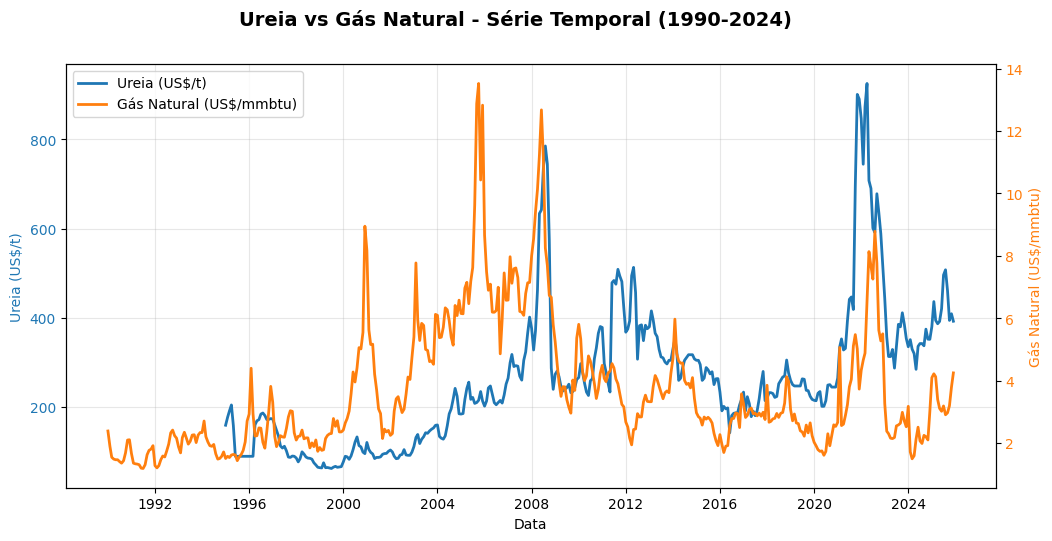

In [26]:
# Gráfico 1: Série temporal - Ureia vs Gás Natural (escala dupla)
fig, ax1 = plt.subplots(figsize=(12, 5.5))

# Eixo esquerdo: Ureia
s_ng = df_merged["natural_gas_usd"].astype(float)
ax1.plot(s_urea.index, s_urea.values, color='C0', linewidth=2, label='Ureia (US$/t)')
ax1.set_xlabel('Data')
ax1.set_ylabel('Ureia (US$/t)', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.grid(True, alpha=0.3)

# Eixo direito: Gás Natural
ax2 = ax1.twinx()
ax2.plot(s_ng.index, s_ng.values, color='C1', linewidth=2, label='Gás Natural (US$/mmbtu)')
ax2.set_ylabel('Gás Natural (US$/mmbtu)', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

fig.suptitle('Ureia vs Gás Natural - Série Temporal (1990-2024)', fontsize=14, fontweight='bold')

# Legenda unificada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

# savefig(fig, '20_urea_vs_gas_timeseries.png')

plt.show()


In [ ]:
# Gráfico 2: Correlação defasada (Ureia vs Gás Natural)
# Calcular correlação com lags de -18 a +18 meses
lc_gas = lagged_corr(s_urea, s_ng, max_lag=18)

# Identificar o melhor lag (máxima correlação em valor absoluto)
best_lag_gas = int(lc_gas.abs().idxmax())
best_corr_gas = float(lc_gas.loc[best_lag_gas])

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(lc_gas.index, lc_gas.values, marker='o', markersize=5, linewidth=2, color='C1')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.axvline(best_lag_gas, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Melhor lag: {best_lag_gas} meses (r={best_corr_gas:.3f})')

ax.set_xlabel('Lag (meses)\nPositivo = Gás antecede Ureia | Negativo = Ureia antecede Gás', fontsize=10)
ax.set_ylabel('Correlação', fontsize=11)
ax.set_title('Correlação Defasada: Ureia vs Gás Natural\n(Defasagem histórica de energía como preditor)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)

savefig(fig, '21_urea_gas_lagged_correlation.png')

# Resumo interpretativo
print("=" * 70)
print("ANÁLISE: UREIA vs GÁS NATURAL (CORRELAÇÃO DEFASADA)")
print("=" * 70)
print(f"\nMelhor lag: {best_lag_gas} meses")
print(f"Correlação no melhor lag: {best_corr_gas:.4f}")
if best_lag_gas > 0:
    print(f"→ Interpretação: Gás Natural ANTECEDE Ureia por ~{best_lag_gas} mês(es)")
    print("  Implicação: Mudanças em preço de gás podem ser sinal antecipado para ureia")
elif best_lag_gas < 0:
    print(f"→ Interpretação: Ureia ANTECEDE Gás Natural por ~{abs(best_lag_gas)} mês(es)")
    print("  Implicação: Mudanças em preço de ureia precedem movimento de gás")
else:
    print("→ Interpretação: Máxima correlação ocorre SEM defasagem")
    print("  Implicação: Movimentos são contemporâneos")

# Top 5 lags positivos (gás antecede)
top_lags = lc_gas.abs().nlargest(5)
print("\n--- Top 5 Lags (por valor absoluto de correlação) ---")
for lag, corr_val in top_lags.items():
    actual_corr = float(lc_gas.loc[lag])
    print(f"  Lag {lag:3d}: corr = {actual_corr:7.4f} (abs: {abs(actual_corr):.4f})")
print("=" * 70)


In [27]:
# Gráfico 3: Correlação móvel (24 meses) para entender variação temporal da relação
rc_gas = rolling_corr(s_urea, s_ng, window=24)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rc_gas.index, rc_gas.values, linewidth=2, color='C1', label='Correlação móvel (24m)')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.fill_between(rc_gas.index, rc_gas.values, 0, alpha=0.3, color='C1')
ax.set_xlabel('Data')
ax.set_ylabel('Correlação (janela 24m)')
ax.set_title('Correlação Móvel: Ureia vs Gás Natural (24 meses)\nMostra variação temporal da relação', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)

savefig(fig, '22_urea_gas_rolling_correlation.png')

# Estatísticas da correlação móvel
print("\n--- Estatísticas da Correlação Móvel (24m) ---")
print(f"Correlação média: {rc_gas.mean():.4f}")
print(f"Desvio-padrão:    {rc_gas.std():.4f}")
print(f"Mínimo:           {rc_gas.min():.4f} (data: {rc_gas.idxmin()})")
print(f"Máximo:           {rc_gas.max():.4f} (data: {rc_gas.idxmax()})")
print(f"Períodos com corr > 0.5:  {(rc_gas > 0.5).sum()} meses")
print(f"Períodos com corr < -0.5: {(rc_gas < -0.5).sum()} meses")


ValueError: cannot reindex on an axis with duplicate labels

In [28]:
# 3) ECM: Δy ~ ΔX + lag(residuals_levels)
y_d = y.diff().dropna()
X_no_const = X.drop(columns=["const"], errors="ignore")
X_d = X_no_const.diff().dropna()

# lag dos resíduos (não restringir ainda)
res_lag = model.resid.shift(1)

# concatenar e alinhar antes de dropar NaNs
ecm_df = pd.concat([X_d, res_lag.rename("ecm")], axis=1)

# intersecção de índices e dropar linhas com NaNs
common_idx = y_d.index.intersection(ecm_df.index)
y_ecm = y_d.loc[common_idx]
X_ecm = ecm_df.loc[common_idx].dropna()

# re-alinhar no caso de dropna ter removido mais linhas
common_idx2 = y_ecm.index.intersection(X_ecm.index)
y_ecm = y_ecm.loc[common_idx2]
X_ecm = X_ecm.loc[common_idx2]

print("ECM shapes:", y_ecm.shape, X_ecm.shape)  # debug rápido

X_ecm = sm.add_constant(X_ecm)
model_ecm = sm.OLS(y_ecm, X_ecm).fit()
print(model_ecm.summary())

InvalidIndexError: Reindexing only valid with uniquely valued Index objects